# Backtesting Evaluation

This notebook evaluates the accuracy and performance of the three-agent system of banks made in this repository with real world data.

```{contents}
```

## Prerequisites

This notebook uses the Federal Reserve Economic Data (FRED) API to import economic data and the OpenAI API to chat with GPT models for each LLM-powered agent. Both require a `.env` file in the root directory of the `agentomics` repository to load the `FRED_API_KEY` and `OPENAI_API_KEY`. Make sure the `.env` file is present in the root directory of the repository and includes the keys before running the notebook.

In [ ]:
import contextlib
import math
import os
import re

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from IPython.display import HTML, display
from langroid.utils.configuration import Settings, set_global

from agentomics.common.data_structures import ThreeBankGlobalState
from agentomics.common.types import NonnegPercent, Percent
from agentomics.utils.fred_download import get_fred_data
from agentomics.utils.fred_post_processing import get_longest_common_date_range
from scripts.economic_simulations.three_banks import simulate_two_way

load_dotenv()

OUTPUT_CSV_PATH = "./notebook_output.csv"
MODEL_NAME = "gpt-4o-mini"

## Gather Input Data

Gather data for the following series from the FRED database: 
* [US GDP Growth Rate](https://fred.stlouisfed.org/series/A191RL1Q225SBEA)
* [US Unemployment Rate](https://fred.stlouisfed.org/series/UNRATE)
* [US Consumer Price Index](https://fred.stlouisfed.org/series/CPIAUCSL)
* [Effective Federal Funds Rate](https://fred.stlouisfed.org/series/FEDFUNDS)
* [Securities Held Outright by the Fed ](https://fred.stlouisfed.org/series/WSHOSHO)  

I chose these series because they correspond to the economic variables and central bank knobs in my `ThreeBanksGlobalState` defined in `agentomics.common.data_structures`. I chose not to include any data about the small or large commercial banks as I figured this data would be proprietary and averaging data to create a representative dataset for these banks would be an arduous task that would slow down backtesting.

In [ ]:
# FRED API details
fred_api_url = "https://api.stlouisfed.org/fred/series/observations"
fred_api_key = os.getenv("FRED_API_KEY")

# Please verify all IDs are still valid
fred_gdp_series_id = "A191RL1Q225SBEA"
fred_unemployment_series_id = "UNRATE"
fred_cpi_series_id = "CPIAUCSL"
fred_fed_funds_rates_series_id = "FEDFUNDS"
fred_fed_securities_series_id = "WSHOSHO"

# Frequency and tine range
frequency = "q"  # Quarterly frequency
observation_start = "2018-01-01"  # Start date for all economic series
observation_end = "2024-01-01"  # End date for all economic series
K = 8  # We take the first 8 rows (2 years) as context

### Download Economic Data

In [ ]:
gdp_df = get_fred_data(fred_gdp_series_id, frequency, observation_start, observation_end, "Quarterly GDP Growth Rate")

# Convert percentages to decimals
gdp_df["Quarterly GDP Growth Rate"] /= 100.0

unemployment_df = get_fred_data(fred_unemployment_series_id, frequency, observation_start, observation_end, "Quarterly Unemployment Rate")

# Convert percentages to decimals
unemployment_df["Quarterly Unemployment Rate"] /= 100.0

cpi_df = get_fred_data(fred_cpi_series_id, frequency, observation_start, observation_end, "Quarterly CPI")

inflation_df = pd.DataFrame()
inflation_df["date"] = cpi_df["date"]
inflation_df["Quarterly Inflation Rate"] = cpi_df["Quarterly CPI"].pct_change()

fed_funds_df = get_fred_data(fred_fed_funds_rates_series_id, frequency, observation_start, observation_end, "Quarterly Effective Federal Funds Rate")

# Convert percentages to decimals
fed_funds_df["Quarterly Effective Federal Funds Rate"] /= 100

fed_securities_df = get_fred_data(fred_fed_securities_series_id, frequency, observation_start, observation_end, "Quarterly Securities Held Outright")

securities_pc_change_df = pd.DataFrame()
securities_pc_change_df["date"] = fed_securities_df["date"]
securities_pc_change_df["Quarterly Securities Held Percent Change"] = fed_securities_df["Quarterly Securities Held Outright"].pct_change()

### Graph Economic Data

#### Reusable function to plot graphs

In [ ]:
def plot_data(plots_info):
    # Calculate grid size
    n_plots = len(plots_info)
    n_cols = math.ceil(math.sqrt(n_plots))  # Number of columns
    n_rows = math.ceil(n_plots / n_cols)    # Number of rows

    # Create subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axs = axs.flatten()  # Flatten the array of axes for easy indexing

    # Plot each dataframe
    for i, plot_info in enumerate(plots_info):
        ax = axs[i]
        df = plot_info["df"]
        x = plot_info["x"]
        y = plot_info["y"]
        ax.plot(
            df[x],
            df[y],
            marker=plot_info.get("marker", "o"),
            linestyle=plot_info.get("linestyle", "-"),
            color=plot_info.get("color", "blue")
        )
        ax.set_title(plot_info.get("title", ""))
        ax.set_xlabel(plot_info.get("xlabel", ""))
        ax.set_ylabel(plot_info.get("ylabel", ""))
        ax.grid(True)
        ax.tick_params(axis="x", rotation=45)

    # Remove any unused subplots
    if n_plots < len(axs):
        for j in range(n_plots, len(axs)):
            fig.delaxes(axs[j])

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the combined plot
    plt.show()

#### Plot Downloaded Data 

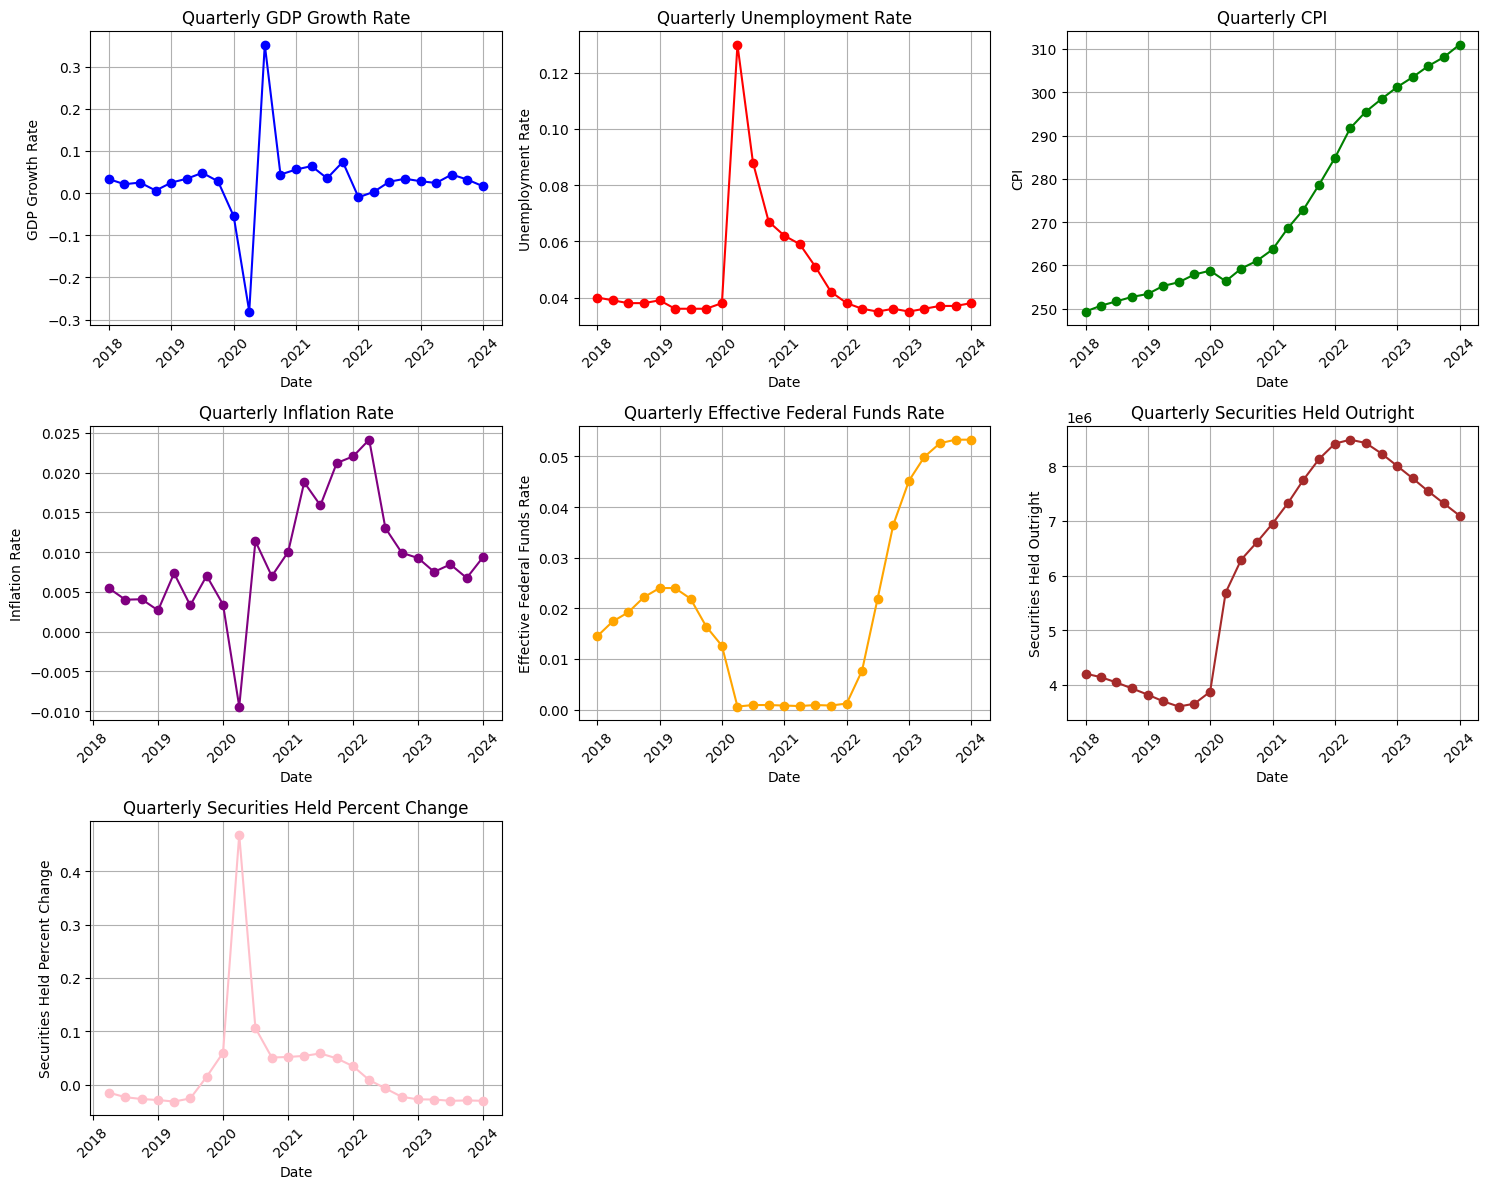

In [ ]:
# List of dictionaries containing plot information for each dataframe
plots_info = [
    {
        "df": gdp_df,
        "x": "date",
        "y": "Quarterly GDP Growth Rate",
        "title": "Quarterly GDP Growth Rate",
        "xlabel": "Date",
        "ylabel": "GDP Growth Rate",
        "marker": "o",
        "linestyle": "-",
        "color": "blue"
    },
    {
        "df": unemployment_df,
        "x": "date",
        "y": "Quarterly Unemployment Rate",
        "title": "Quarterly Unemployment Rate",
        "xlabel": "Date",
        "ylabel": "Unemployment Rate",
        "marker": "o",
        "linestyle": "-",
        "color": "red"
    },
    {
        "df": cpi_df,
        "x": "date",
        "y": "Quarterly CPI",
        "title": "Quarterly CPI",
        "xlabel": "Date",
        "ylabel": "CPI",
        "marker": "o",
        "linestyle": "-",
        "color": "green"
    },
    {
        "df": inflation_df,
        "x": "date",
        "y": "Quarterly Inflation Rate",
        "title": "Quarterly Inflation Rate",
        "xlabel": "Date",
        "ylabel": "Inflation Rate",
        "marker": "o",
        "linestyle": "-",
        "color": "purple"
    },
    # Add your remaining dataframes here
    {
        "df": fed_funds_df,
        "x": "date",
        "y": "Quarterly Effective Federal Funds Rate",
        "title": "Quarterly Effective Federal Funds Rate",
        "xlabel": "Date",
        "ylabel": "Effective Federal Funds Rate",
        "marker": "o",
        "linestyle": "-",
        "color": "orange"
    },
    {
        "df": fed_securities_df,
        "x": "date",
        "y": "Quarterly Securities Held Outright",
        "title": "Quarterly Securities Held Outright",
        "xlabel": "Date",
        "ylabel": "Securities Held Outright",
        "marker": "o",
        "linestyle": "-",
        "color": "brown"
    },
    {
        "df": securities_pc_change_df,
        "x": "date",
        "y": "Quarterly Securities Held Percent Change",
        "title": "Quarterly Securities Held Percent Change",
        "xlabel": "Date",
        "ylabel": "Securities Held Percent Change",
        "marker": "o",
        "linestyle": "-",
        "color": "pink"
    }
]

plot_data(plots_info)

### Clean Input Data

Select the longest continuous block from all series that does not contain any `NaN`s. This will conform to what the simulation expects while ensuring that we have no `NaN` values.

In [ ]:
clean_df = get_longest_common_date_range([gdp_df,
                                          unemployment_df, cpi_df, inflation_df, fed_funds_df, fed_securities_df, securities_pc_change_df])

display(clean_df)

,date,Quarterly GDP Growth Rate,Quarterly Unemployment Rate,Quarterly CPI,Quarterly Inflation Rate,Quarterly Effective Federal Funds Rate,Quarterly Securities Held Outright,Quarterly Securities Held Percent Change
0,2018-04-01,0.021,0.039,250.679,0.005443,0.0174,4139936,-0.015221
1,2018-07-01,0.025,0.038,251.686,0.004017,0.0192,4042184,-0.023612
2,2018-10-01,0.006,0.038,252.711,0.004073,0.0222,3932744,-0.027074
3,2019-01-01,0.025,0.039,253.386,0.002671,0.0240,3818842,-0.028962
4,2019-04-01,0.034,0.036,255.247,0.007345,0.0240,3697363,-0.031810
5,2019-07-01,0.048,0.036,256.089,0.003299,0.0219,3601414,-0.025951
6,2019-10-01,0.028,0.036,257.888,0.007025,0.0164,3653937,0.014584
7,2020-01-01,-0.055,0.038,258.767,0.003408,0.0126,3872303,0.059762
8,2020-04-01,-0.281,0.130,256.326,-0.009433,0.0006,5687418,0.468743
9,2020-07-01,0.352,0.088,259.242,0.011376,0.0009,6290358,0.106013


#### Plot Cleaned Data

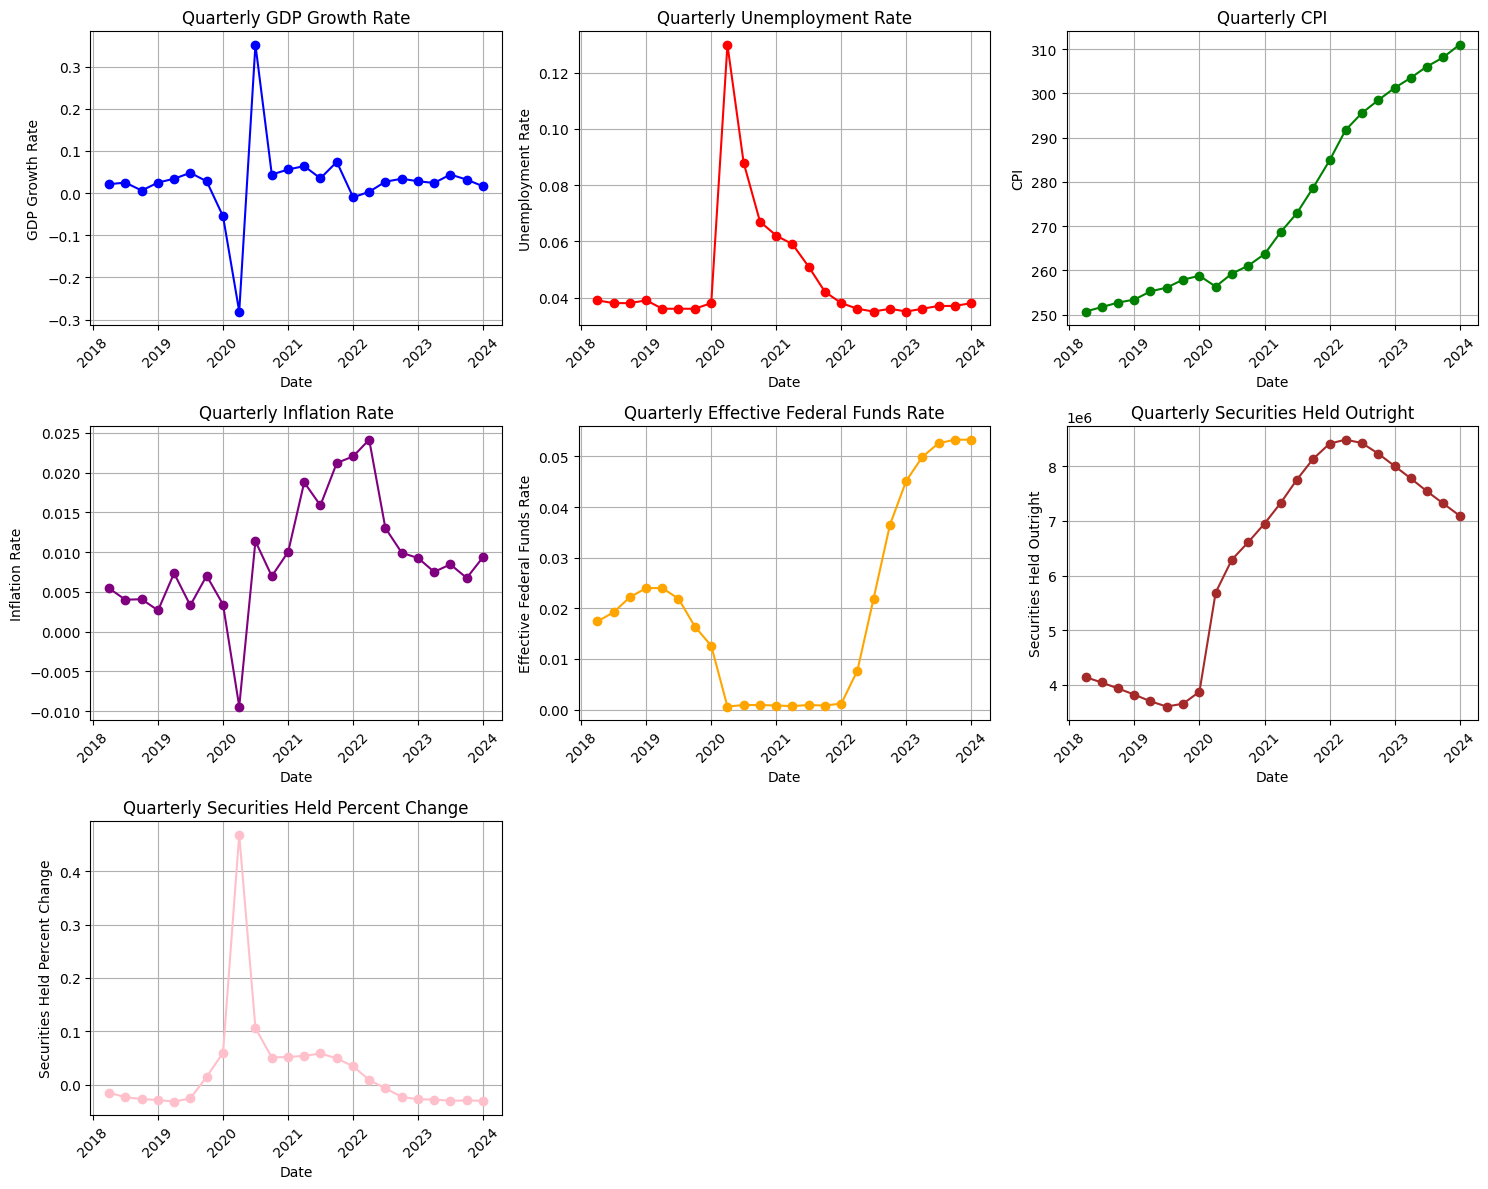

In [ ]:
plots_info = [
    {
        "df": clean_df[["date", "Quarterly GDP Growth Rate"]],
        "x": "date",
        "y": "Quarterly GDP Growth Rate",
        "title": "Quarterly GDP Growth Rate",
        "xlabel": "Date",
        "ylabel": "GDP Growth Rate",
        "marker": "o",
        "linestyle": "-",
        "color": "blue"
    },
    {
        "df": clean_df[["date", "Quarterly Unemployment Rate"]],
        "x": "date",
        "y": "Quarterly Unemployment Rate",
        "title": "Quarterly Unemployment Rate",
        "xlabel": "Date",
        "ylabel": "Unemployment Rate",
        "marker": "o",
        "linestyle": "-",
        "color": "red"
    },
    {
        "df": clean_df[["date", "Quarterly CPI"]],
        "x": "date",
        "y": "Quarterly CPI",
        "title": "Quarterly CPI",
        "xlabel": "Date",
        "ylabel": "CPI",
        "marker": "o",
        "linestyle": "-",
        "color": "green"
    },
    {
        "df": clean_df[["date", "Quarterly Inflation Rate"]],
        "x": "date",
        "y": "Quarterly Inflation Rate",
        "title": "Quarterly Inflation Rate",
        "xlabel": "Date",
        "ylabel": "Inflation Rate",
        "marker": "o",
        "linestyle": "-",
        "color": "purple"
    },
    {
        "df": clean_df[["date", "Quarterly Effective Federal Funds Rate"]],
        "x": "date",
        "y": "Quarterly Effective Federal Funds Rate",
        "title": "Quarterly Effective Federal Funds Rate",
        "xlabel": "Date",
        "ylabel": "Effective Federal Funds Rate",
        "marker": "o",
        "linestyle": "-",
        "color": "orange"
    },
    {
        "df": clean_df[["date", "Quarterly Securities Held Outright"]],
        "x": "date",
        "y": "Quarterly Securities Held Outright",
        "title": "Quarterly Securities Held Outright",
        "xlabel": "Date",
        "ylabel": "Securities Held Outright",
        "marker": "o",
        "linestyle": "-",
        "color": "brown"
    },
    {
        "df": clean_df[["date", "Quarterly Securities Held Percent Change"]],
        "x": "date",
        "y": "Quarterly Securities Held Percent Change",
        "title": "Quarterly Securities Held Percent Change",
        "xlabel": "Date",
        "ylabel": "Securities Held Percent Change",
        "marker": "o",
        "linestyle": "-",
        "color": "pink"
    }
]

plot_data(plots_info)

### Plot Downloaded vs Cleaned Data

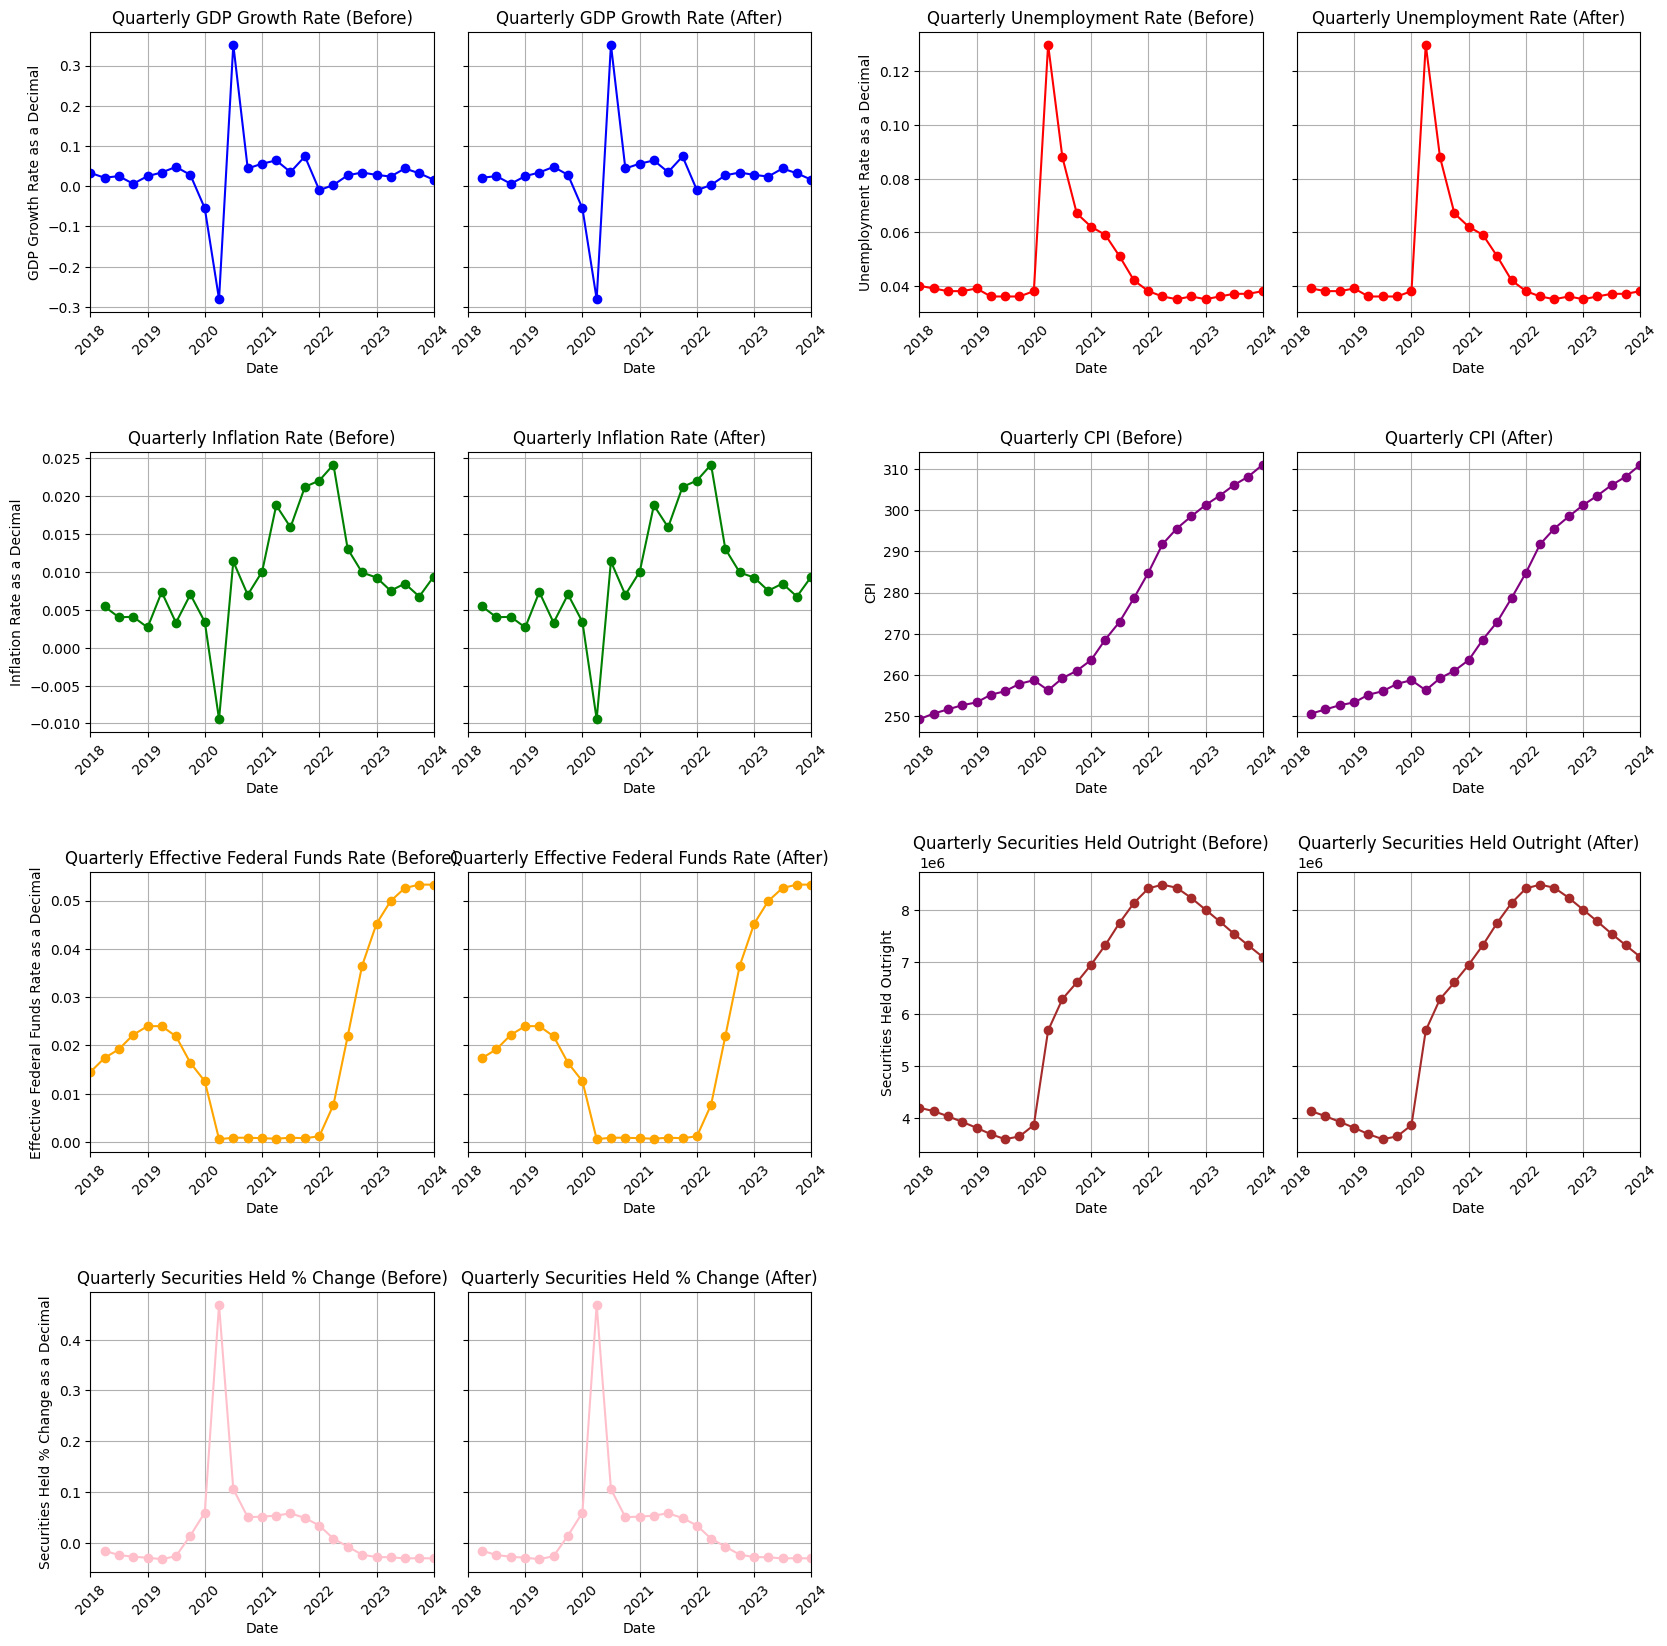

In [ ]:
# Ensure 'date' columns are in datetime format for all DataFrames
for df in [
    gdp_df,
    unemployment_df,
    inflation_df,
    cpi_df,
    clean_df,
    fed_funds_df,
    fed_securities_df,
    securities_pc_change_df
]:
    df["date"] = pd.to_datetime(df["date"])

# Determine the overall date range
all_dates = pd.concat([
    gdp_df["date"],
    unemployment_df["date"],
    inflation_df["date"],
    cpi_df["date"],
    clean_df["date"],
    fed_funds_df["date"],
    fed_securities_df["date"],
    securities_pc_change_df["date"]
])

min_date = all_dates.min()
max_date = all_dates.max()

# Create a common date range for x-ticks (e.g., quarterly)
# common_dates = pd.date_range(start=min_date, end=max_date, freq="QS")  # 'QS' stands for Quarter Start

# Variables to plot
variables = [
    {
        "name": "Quarterly GDP Growth Rate",
        "before_df": gdp_df,
        "before_col": "Quarterly GDP Growth Rate",
        "after_col": "Quarterly GDP Growth Rate",
        "ylabel": "GDP Growth Rate as a Decimal",
        "color": "blue"
    },
    {
        "name": "Quarterly Unemployment Rate",
        "before_df": unemployment_df,
        "before_col": "Quarterly Unemployment Rate",
        "after_col": "Quarterly Unemployment Rate",
        "ylabel": "Unemployment Rate as a Decimal",
        "color": "red"
    },
    {
        "name": "Quarterly Inflation Rate",
        "before_df": inflation_df,
        "before_col": "Quarterly Inflation Rate",
        "after_col": "Quarterly Inflation Rate",
        "ylabel": "Inflation Rate as a Decimal",
        "color": "green"
    },
    {
        "name": "Quarterly CPI",
        "before_df": cpi_df,
        "before_col": "Quarterly CPI",
        "after_col": "Quarterly CPI",
        "ylabel": "CPI",
        "color": "purple"
    },
    {
        "name": "Quarterly Effective Federal Funds Rate",
        "before_df": fed_funds_df,
        "before_col": "Quarterly Effective Federal Funds Rate",
        "after_col": "Quarterly Effective Federal Funds Rate",
        "ylabel": "Effective Federal Funds Rate as a Decimal",
        "color": "orange"
    },
    {
        "name": "Quarterly Securities Held Outright",
        "before_df": fed_securities_df,
        "before_col": "Quarterly Securities Held Outright",
        "after_col": "Quarterly Securities Held Outright",
        "ylabel": "Securities Held Outright",
        "color": "brown"
    },
    {
        "name": "Quarterly Securities Held % Change",
        "before_df": securities_pc_change_df,
        "before_col": "Quarterly Securities Held Percent Change",
        "after_col": "Quarterly Securities Held Percent Change",
        "ylabel": "Securities Held % Change as a Decimal",
        "color": "pink"
    }
]

# Calculate the number of rows needed for the outer grid
num_variables = len(variables)
num_outer_cols = 2  # Keep 2 columns for side-by-side comparison
num_outer_rows = math.ceil(num_variables / num_outer_cols)

# Create a figure with adjusted height
fig = plt.figure(figsize=(20, 5 * num_outer_rows))

# Create an outer GridSpec with the calculated number of rows and columns
outer_grid = gridspec.GridSpec(num_outer_rows, num_outer_cols, wspace=0.15, hspace=0.5)

for idx, var in enumerate(variables):
    # Extract data and column names
    before_df = var["before_df"]
    before_col = var["before_col"]
    after_col = var["after_col"]
    ylabel = var["ylabel"]
    color = var["color"]
    name = var["name"]

    # Create an inner GridSpec within the current outer grid cell
    inner_grid = gridspec.GridSpecFromSubplotSpec(
        1, 2, subplot_spec=outer_grid[idx], wspace=0.1
    )

    # Before and After Axes, sharing y-axis
    ax_before = fig.add_subplot(inner_grid[0])
    ax_after = fig.add_subplot(inner_grid[1], sharey=ax_before)

    # Plot Before Cleaning Data
    ax_before.plot(
        before_df["date"], before_df[before_col],
        linestyle="-", marker="o", color=color
    )
    ax_before.set_title(f"{name} (Before)")
    ax_before.set_xlabel("Date")
    ax_before.set_ylabel(ylabel)
    ax_before.grid(True)
    ax_before.tick_params(axis="x", rotation=45)

    # Plot After Cleaning Data
    ax_after.plot(
        clean_df["date"], clean_df[after_col],
        linestyle="-", marker="o", color=color
    )
    ax_after.set_title(f"{name} (After)")
    ax_after.set_xlabel("Date")
    ax_after.grid(True)
    ax_after.tick_params(axis="x", rotation=45)

    # Set the same x-axis limits and ticks for both subplots
    for ax in [ax_before, ax_after]:
        ax.set_xlim([min_date, max_date])
        # # Correctly format the date labels with year and quarter
        # ax.set_xticklabels(
        #     [f"{date.year}-Q{((date.month - 1)//3 + 1)}" for date in common_dates],
        #     rotation=45
        # )
        # ax.xaxis.set_major_formatter(plt.NullFormatter())  # Hide default x-axis labels
        # ax.xaxis.set_minor_formatter(plt.NullFormatter())

    # Remove y-tick labels on the right subplot to avoid duplication
    plt.setp(ax_after.get_yticklabels(), visible=False)

# Optionally, adjust the x-axis labels after tight_layout
for ax in fig.get_axes():
    ax.set_xlabel("Date")
    # ax.set_xticks(common_dates)
    # ax.set_xticklabels(
    #     [f"{date.year}-Q{((date.month - 1)//3 + 1)}" for date in common_dates],
    #     rotation=45
    # )

# Display the plot
plt.show()

## Run Backtesting

### Create Global State for Simulation

In [ ]:
# Set up data to put into simulation
N = len(clean_df)

sub_df = clean_df.head(K)
gdp_input = list(map(Percent, sub_df["Quarterly GDP Growth Rate"].tolist()))
unemployment_input = list(map(NonnegPercent, sub_df["Quarterly Unemployment Rate"].tolist()))
inflation_input = list(map(Percent, sub_df["Quarterly Inflation Rate"].tolist()))
target_interest_rate_input = list(map(NonnegPercent, sub_df["Quarterly Effective Federal Funds Rate"].tolist()))
securities_holdings_pc_change_input = list(map(Percent, sub_df["Quarterly Securities Held Percent Change"].tolist()))
# Set all knobs to N/A [== -infinity for the custom types]
loan_to_deposit_ratio_input = [NonnegPercent(float("-inf"))] * K
deposit_interest_rate_input = [NonnegPercent(float("-inf"))] * K
loans_interest_rate_input = [NonnegPercent(float("-inf"))] * K
consumer_loan_focus_input = [NonnegPercent(float("-inf"))] * K

globals = ThreeBankGlobalState()
globals.economic_variables.gdp_growth_rate.set_array(gdp_input)
globals.economic_variables.unemployment_rate.set_array(unemployment_input)
globals.economic_variables.inflation_rate.set_array(inflation_input)
globals.central_bank_knobs.target_interest_rate.set_array(target_interest_rate_input)
globals.central_bank_knobs.securities_holdings_pc_change.set_array(securities_holdings_pc_change_input)
globals.big_bank_knobs.loan_to_deposit_ratio.set_array(loan_to_deposit_ratio_input)
globals.big_bank_knobs.deposit_interest_rate.set_array(deposit_interest_rate_input)
globals.small_bank_knobs.loans_interest_rate.set_array(loans_interest_rate_input)
globals.small_bank_knobs.consumer_loan_focus.set_array(consumer_loan_focus_input)
globals.number_of_quarters_to_simulate = N - K

globals_pd = globals.to_pandas_df()

### Run Simulation
We want to capture all the interactions between the simulation framework and LLM for analysis.

TODO: We are missing the prompts sent to LLMs and status updates from Langroid. Figure out how to capture this for comprehensive analysis and debugging.

In [ ]:
log_file_path = "./simulation_output.log"

# Open the log file in write mode
with open(log_file_path, "w") as log_file:
    # Redirect both stdout and stderr to the log file
    with contextlib.redirect_stdout(log_file), contextlib.redirect_stderr(log_file):
        set_global(Settings(notebook=True))
        simulate_two_way(globals, MODEL_NAME, outfile=OUTPUT_CSV_PATH)

2024-11-30 09:32:40 - WARNING - REDIS_PASSWORD, REDIS_HOST, REDIS_PORT not set in .env file,
                        using fake redis client


>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1050, out=406, max=1024, ctx=128000, COST: now=$0.0004, cumul=$0.0004, tot=$0.0004 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1084, out=384, max=1024, ctx=128000, COST: now=$0.0004, cumul=$0.0004, tot=$0.0008 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1064, out=441, max=1024, ctx=128000, COST: now=$0.0004, cumul=$0.0004, tot=$0.0012 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1277, out=372, max=1024, ctx=128000, COST: now=$0.0004, cumul=$0.0004, tot=$0.0016 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1104, out=403, max=1024, ctx=128000, COST: now=$0.0004, cumul=$0.0004, tot=$0.0020 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1138, out=432, max=1024, ctx=128000, COST: now=$0.0004, cumul=$0.0004, tot=$0.0025 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1118, out=480, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0029 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1327, out=388, max=1024, ctx=128000, COST: now=$0.0004, cumul=$0.0004, tot=$0.0034 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1149, out=490, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0038 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1188, out=442, max=1024, ctx=128000, COST: now=$0.0004, cumul=$0.0004, tot=$0.0043 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1168, out=562, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0048 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1377, out=332, max=1024, ctx=128000, COST: now=$0.0004, cumul=$0.0004, tot=$0.0052 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1204, out=456, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0056 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1238, out=468, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0061 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1218, out=431, max=1024, ctx=128000, COST: now=$0.0004, cumul=$0.0004, tot=$0.0065 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1427, out=400, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0070 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1254, out=419, max=1024, ctx=128000, COST: now=$0.0004, cumul=$0.0004, tot=$0.0074 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1288, out=475, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0079 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1268, out=533, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0084 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1482, out=348, max=1024, ctx=128000, COST: now=$0.0004, cumul=$0.0004, tot=$0.0089 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1309, out=420, max=1024, ctx=128000, COST: now=$0.0004, cumul=$0.0004, tot=$0.0093 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1343, out=431, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0098 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1323, out=546, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0103 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1537, out=387, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0108 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1359, out=470, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0112 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1393, out=471, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0117 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1373, out=534, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0123 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1587, out=475, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0128 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1409, out=435, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0133 
(gpt-4o-mini)

Agent: 

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1409, out=460, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0137 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1443, out=465, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0142 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1423, out=583, max=1024, ctx=128000, COST: now=$0.0006, cumul=$0.0006, tot=$0.0148 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1632, out=344, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0153 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1454, out=403, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0157 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1488, out=406, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0162 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1468, out=517, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0167 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1682, out=348, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0172 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1504, out=460, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0177 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1538, out=415, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0182 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1518, out=464, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0187 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1737, out=365, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0191 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1559, out=442, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0196 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1593, out=470, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0202 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1573, out=508, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0207 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1787, out=332, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0212 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1614, out=397, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0216 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1648, out=492, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0222 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1628, out=490, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0227 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1842, out=317, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0232 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1674, out=404, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0237 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1708, out=452, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0242 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1688, out=534, max=1024, ctx=128000, COST: now=$0.0006, cumul=$0.0006, tot=$0.0248 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1902, out=323, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0253 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1734, out=397, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0258 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1768, out=424, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0263 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1748, out=536, max=1024, ctx=128000, COST: now=$0.0006, cumul=$0.0006, tot=$0.0269 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1962, out=379, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0274 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1794, out=456, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0279 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1828, out=469, max=1024, ctx=128000, COST: now=$0.0006, cumul=$0.0006, tot=$0.0285 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1808, out=503, max=1024, ctx=128000, COST: now=$0.0006, cumul=$0.0006, tot=$0.0291 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=2017, out=322, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0296 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

>>> Starting Agent CentralBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1849, out=421, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0301 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent CentralBank (3) 

>>> Starting Agent BigBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1883, out=439, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0306 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent BigBank (3) 

>>> Starting Agent SmallBank (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=1863, out=453, max=1024, ctx=128000, COST: now=$0.0006, cumul=$0.0006, tot=$0.0312 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent SmallBank (3) 

>>> Starting Agent EconomyAgent (1) gpt-4o-mini 

Stats: N_MSG=2, TOKENS: in=2082, out=323, max=1024, ctx=128000, COST: now=$0.0005, cumul=$0.0005, tot=$0.0317 
(gpt-4o-mini)

Bye, hope this was useful!

<<< Finished Agent EconomyAgent (3) 

### Clean Up and Print Simulation Logs
Here we use a regular expressions matcher to remove the color coding in logs. We use some custom HTML code that we inject into the notebook to print the log as a collapsible section.

In [ ]:
# Read the contents of the log file into a string
with open(log_file_path, "r") as log_file:
    log_contents = log_file.read()

# HTML for collapsible section
clean_output = re.sub(r"\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])|\[\d+m", "", log_contents)

collapsible_html = f"""
<div>
    <button onclick="this.nextElementSibling.style.display =
    (this.nextElementSibling.style.display === 'none') ? 'block' : 'none';">
        Show/Hide Text Output
    </button>
    <div style="display: none; margin-top: 10px;">
        <pre style="white-space: pre-wrap; font-family: inherit;">{clean_output}</pre>
    </div>
</div>
"""

# Display the collapsible section
display(HTML(collapsible_html))

### Save Global State

In [ ]:
globals_pd = globals.to_pandas_df()
globals_pd.to_csv(OUTPUT_CSV_PATH)
globals_pd = pd.read_csv(OUTPUT_CSV_PATH)
display(globals_pd)

,Unnamed: 0,gdp_growth_rate,unemployment_rate,inflation_rate,target_interest_rate,total_securities_holdings,loan_to_deposit_ratio,deposit_interest_rate,loans_interest_rate,consumer_loan_focus
0,0,0.021,0.039,0.005443,0.0174,-0.015221,-inf,-inf,-inf,-inf
1,1,0.025,0.038,0.004017,0.0192,-0.023612,-inf,-inf,-inf,-inf
2,2,0.006,0.038,0.004073,0.0222,-0.027074,-inf,-inf,-inf,-inf
3,3,0.025,0.039,0.002671,0.0240,-0.028962,-inf,-inf,-inf,-inf
4,4,0.034,0.036,0.007345,0.0240,-0.031810,-inf,-inf,-inf,-inf
5,5,0.048,0.036,0.003299,0.0219,-0.025951,-inf,-inf,-inf,-inf
6,6,0.028,0.036,0.007025,0.0164,0.014584,-inf,-inf,-inf,-inf
7,7,-0.055,0.038,0.003408,0.0126,0.059762,-inf,-inf,-inf,-inf
8,8,0.012,0.041,0.002500,0.0100,0.100000,0.75,0.0050,0.0300,0.70
9,9,0.020,0.040,0.004000,0.0100,0.050000,0.80,0.0040,0.0250,0.65


### Plot Predicted vs Observed Values
The first $K$ values are used to create the context. Thus, the predicated and observed values will be same for the first $K$ observations.

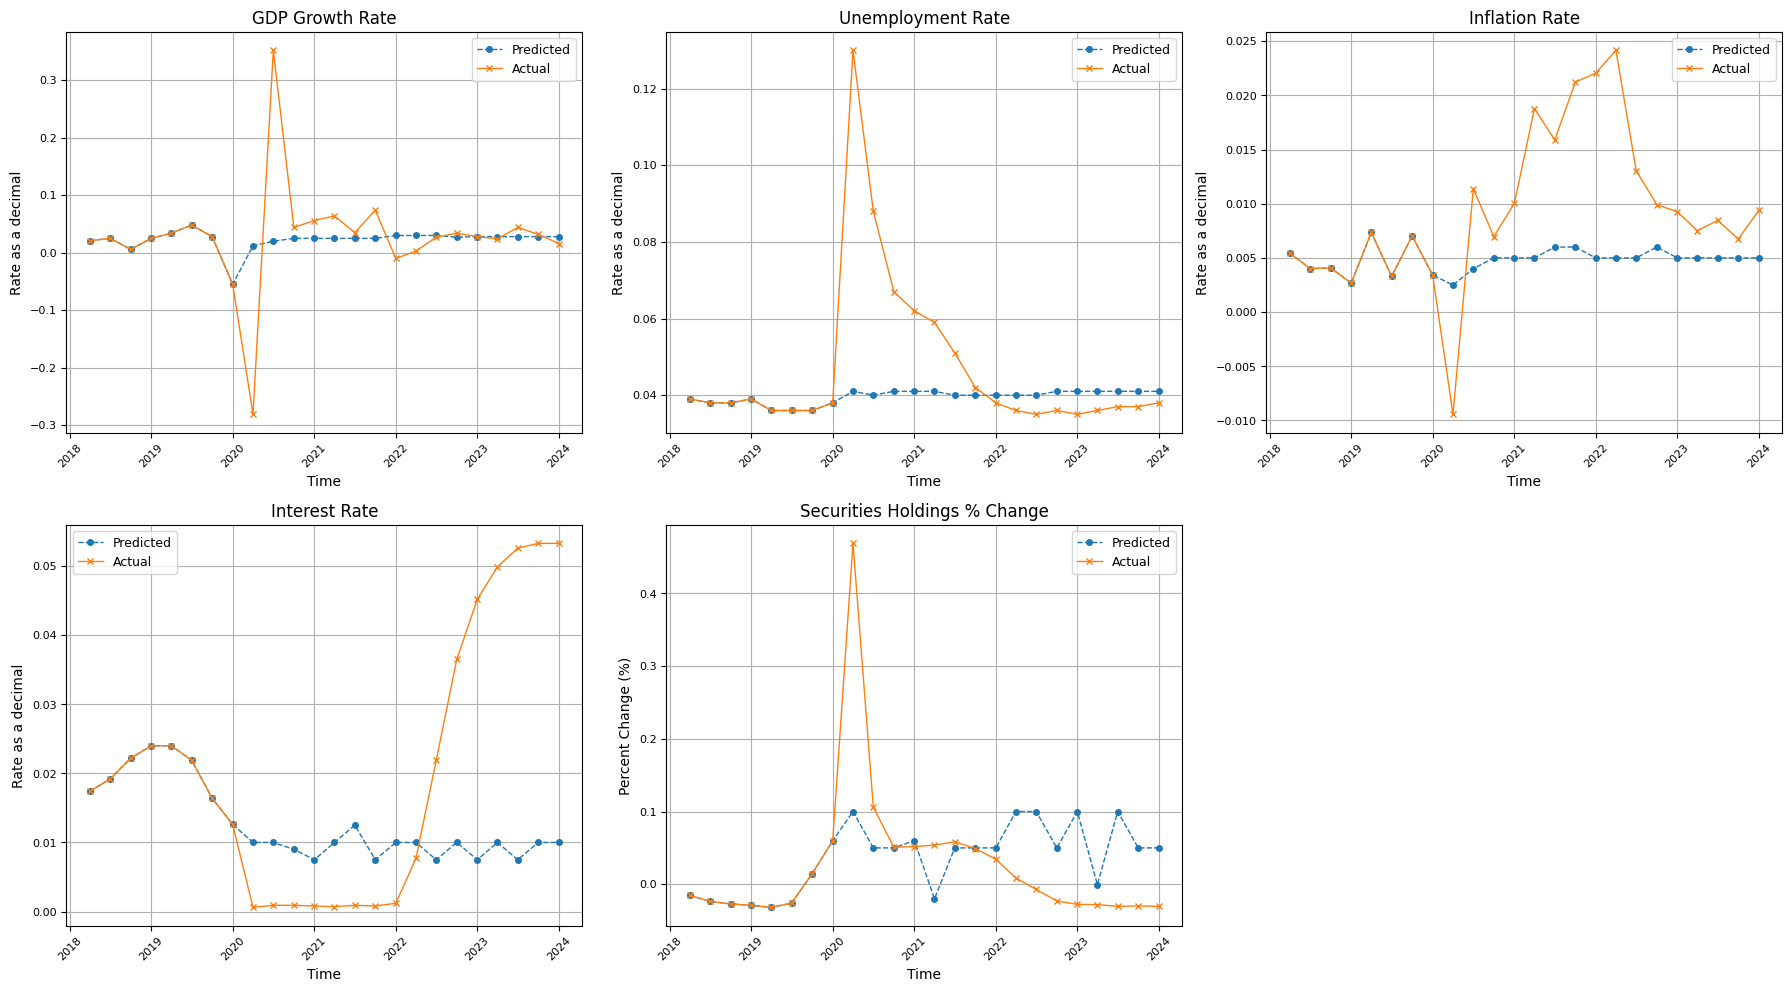

In [ ]:
join_df = clean_df.join(globals_pd)

# Create subplots with 2 rows and 3 columns (to accommodate 5 plots)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.25, hspace=0.4)

# ---------------------
# GDP Growth Rate Plot (axes[0])
# ---------------------

# Select the columns for GDP growth rate and drop NaN values
compare_gdp_df = join_df[["date", "gdp_growth_rate", "Quarterly GDP Growth Rate"]].dropna()

# Plot the predicted GDP growth rate
axes[0].plot(compare_gdp_df["date"], compare_gdp_df["gdp_growth_rate"],
             label="Predicted", linestyle="--", marker="o", markersize=4, linewidth=1)

# Plot the actual GDP growth rate
axes[0].plot(compare_gdp_df["date"], compare_gdp_df["Quarterly GDP Growth Rate"],
             label="Actual", linestyle="-", marker="x", markersize=4, linewidth=1)

# Customize the GDP plot
axes[0].set_title("GDP Growth Rate", fontsize=12)
axes[0].set_xlabel("Time", fontsize=10)
axes[0].set_ylabel("Rate as a decimal", fontsize=10)
axes[0].legend(fontsize=9)
axes[0].grid(True)
axes[0].tick_params(axis="x", rotation=45, labelsize=8)
axes[0].tick_params(axis="y", labelsize=8)

# ---------------------
# Unemployment Rate Plot (axes[1])
# ---------------------

# Select the columns for the unemployment rate and drop NaN values
compare_unemp_df = join_df[["date", "unemployment_rate", "Quarterly Unemployment Rate"]].dropna()

# Plot the predicted unemployment rate
axes[1].plot(compare_unemp_df["date"], compare_unemp_df["unemployment_rate"],
             label="Predicted", linestyle="--", marker="o", markersize=4, linewidth=1)

# Plot the actual unemployment rate
axes[1].plot(compare_unemp_df["date"], compare_unemp_df["Quarterly Unemployment Rate"],
             label="Actual", linestyle="-", marker="x", markersize=4, linewidth=1)

# Customize the unemployment plot
axes[1].set_title("Unemployment Rate", fontsize=12)
axes[1].set_xlabel("Time", fontsize=10)
axes[1].set_ylabel("Rate as a decimal", fontsize=10)
axes[1].legend(fontsize=9)
axes[1].grid(True)
axes[1].tick_params(axis="x", rotation=45, labelsize=8)
axes[1].tick_params(axis="y", labelsize=8)

# ---------------------
# Inflation Rate Plot (axes[2])
# ---------------------

# Select the columns for the inflation rate and drop NaN values
compare_inflation_df = join_df[["date", "inflation_rate", "Quarterly Inflation Rate"]].dropna()

# Plot the predicted inflation rate
axes[2].plot(compare_inflation_df["date"], compare_inflation_df["inflation_rate"],
             label="Predicted", linestyle="--", marker="o", markersize=4, linewidth=1)

# Plot the actual inflation rate
axes[2].plot(compare_inflation_df["date"], compare_inflation_df["Quarterly Inflation Rate"],
             label="Actual", linestyle="-", marker="x", markersize=4, linewidth=1)

# Customize the inflation plot
axes[2].set_title("Inflation Rate", fontsize=12)
axes[2].set_xlabel("Time", fontsize=10)
axes[2].set_ylabel("Rate as a decimal", fontsize=10)
axes[2].legend(fontsize=9)
axes[2].grid(True)
axes[2].tick_params(axis="x", rotation=45, labelsize=8)
axes[2].tick_params(axis="y", labelsize=8)

# ---------------------
# Target Interest Rate Plot (axes[3])
# ---------------------

# Select the columns for the interest rate and drop NaN values
compare_interest_df = join_df[["date", "target_interest_rate", "Quarterly Effective Federal Funds Rate"]].dropna()

# Plot the predicted target interest rate
axes[3].plot(compare_interest_df["date"], compare_interest_df["target_interest_rate"],
             label="Predicted", linestyle="--", marker="o", markersize=4, linewidth=1)

# Plot the actual effective federal funds rate
axes[3].plot(compare_interest_df["date"], compare_interest_df["Quarterly Effective Federal Funds Rate"],
             label="Actual", linestyle="-", marker="x", markersize=4, linewidth=1)

# Customize the interest rate plot
axes[3].set_title("Interest Rate", fontsize=12)
axes[3].set_xlabel("Time", fontsize=10)
axes[3].set_ylabel("Rate as a decimal", fontsize=10)
axes[3].legend(fontsize=9)
axes[3].grid(True)
axes[3].tick_params(axis="x", rotation=45, labelsize=8)
axes[3].tick_params(axis="y", labelsize=8)

# ---------------------
# Securities Holdings Percent Change Plot (axes[4])
# ---------------------

# Select the columns for securities holdings percent change and drop NaN values
compare_securities_df = join_df[["date", "total_securities_holdings", "Quarterly Securities Held Percent Change"]].dropna()

# Plot the predicted securities holdings percent change
axes[4].plot(compare_securities_df["date"], compare_securities_df["total_securities_holdings"],
             label="Predicted", linestyle="--", marker="o", markersize=4, linewidth=1)

# Plot the actual securities held percent change
axes[4].plot(compare_securities_df["date"], compare_securities_df["Quarterly Securities Held Percent Change"],
             label="Actual", linestyle="-", marker="x", markersize=4, linewidth=1)

# Customize the securities holdings plot
axes[4].set_title("Securities Holdings % Change", fontsize=12)
axes[4].set_xlabel("Time", fontsize=10)
axes[4].set_ylabel("Percent Change (%)", fontsize=10)
axes[4].legend(fontsize=9)
axes[4].grid(True)
axes[4].tick_params(axis="x", rotation=45, labelsize=8)
axes[4].tick_params(axis="y", labelsize=8)

# Hide the last subplot (axes[5]) if not used
fig.delaxes(axes[5])

# Adjust layout
plt.tight_layout(pad=1.0)
plt.show()